In [72]:
#Importing important packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10


from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense


from sklearn.preprocessing import MinMaxScaler

In [73]:
#Importing historical stock data
df=pd.read_csv("D:\\Hackathon\\Stock Price Prediction\\TCS.NS.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-01,1219.500000,1219.500000,1206.125000,1208.199951,1062.938354,712262
1,2016-01-04,1205.074951,1207.000000,1183.025024,1184.800049,1042.351440,1870184
2,2016-01-05,1192.500000,1193.300049,1170.500000,1174.474976,1033.268066,2678020
3,2016-01-06,1175.099976,1193.074951,1175.099976,1190.800049,1047.630249,2653228
4,2016-01-07,1185.000000,1191.449951,1180.000000,1185.625000,1043.077148,3199580


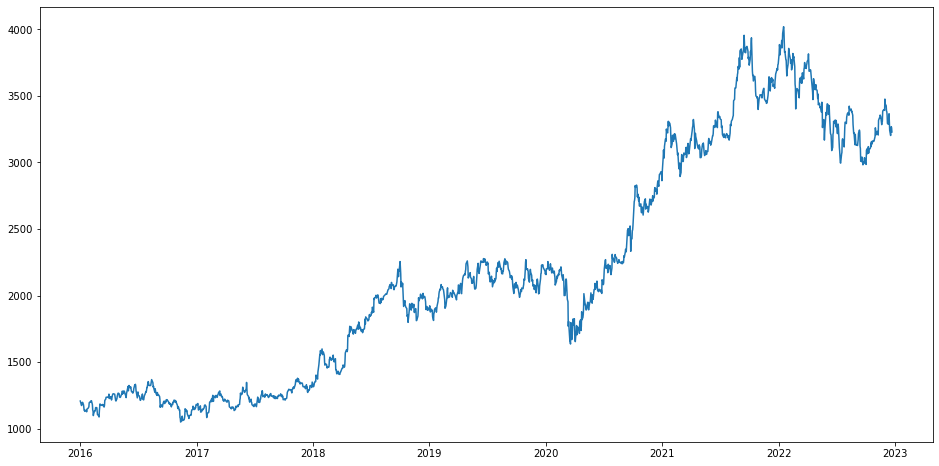

In [74]:
#Indexing Date Column and visualizing to see the trend

df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [75]:
#sorting dataset on date and filtering only date and time
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

#creating a new dataset with two columns
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

In [77]:
#adding date to index and dropping date column
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values

#breaking data set into training and validation with ~80%:20%
train_data=final_dataset[0:1360,:]
valid_data=final_dataset[1360:,:]

#transforming closing price with MinMAxScalar
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)


x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [78]:
#building and training data with the LSTM model
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

In [79]:
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

1300/1300 - 26s - loss: 0.0012 - 26s/epoch - 20ms/step


In [80]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

In [81]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
closing_price=lstm_model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)

lstm_model.save("saved_lstm_model.h5")


12/12 [==============================] - 1s 12ms/step


C:\Users\hussa\AppData\Local\Temp/ipykernel_9316/4179830896.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=closing_price


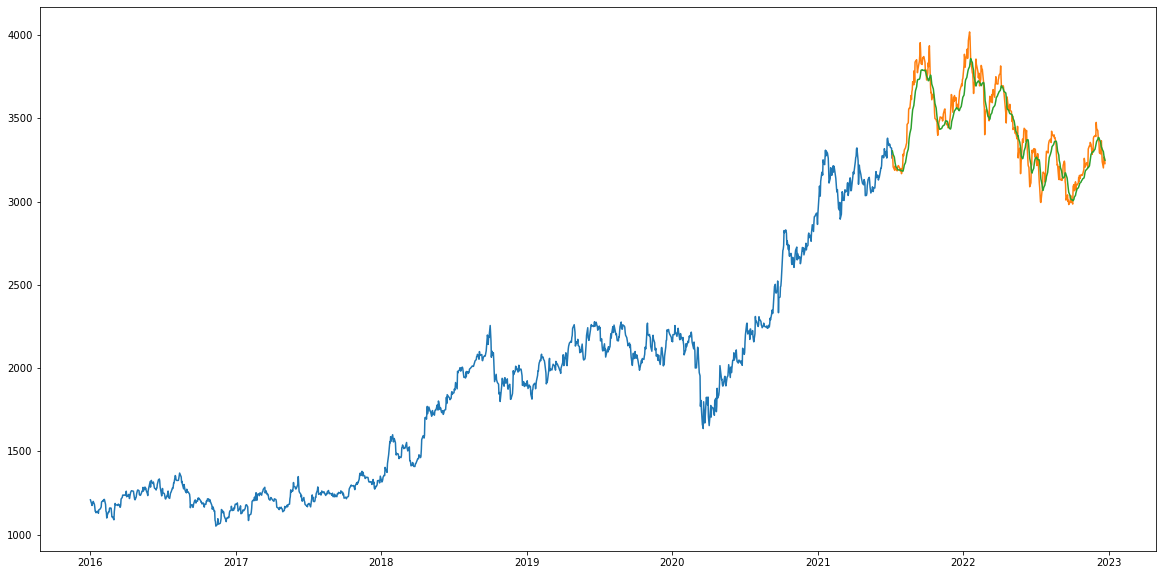

In [83]:
#Checking graphically train actual and predicted data
train_data=new_dataset[:1360]
valid_data=new_dataset[1360:]
valid_data['Predictions']=closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])